Causal-Aware Portfolio Analysis Notebook (Python 3.11)
======================================================

Usage
-----
Run each cell top-to-bottom.  The *CONFIG* block is the only place you
need to edit when you want to change:

* asset universe              →  `TICKERS`
* date range                  →  `START`, `END`
* return frequency            →  `FREQ` (`'D'`, `'W'`, `'M'`, …)
* max lag for the PC algorithm→  `MAX_LAG`
* conditional-independence test→  `CI_TEST` (`'pearson'` or `'kernel'`)
* risk-aversion               →  `RISK_AVERSION`

In [1]:
from __future__ import annotations

from dataclasses import dataclass, field
from itertools import combinations
from typing import Iterable, Literal

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns
import yfinance as yf
from numpy.linalg import pinv
from scipy.optimize import minimize
from scipy.spatial.distance import pdist, squareform
from scipy.stats import pearsonr
from sklearn.covariance import LedoitWolf
from sklearn.preprocessing import StandardScaler, scale

# Configuration
# -------------
# Edit values here only.

In [2]:
@dataclass(slots=True)
class Config:
    tickers: list[str] = field(
        default_factory=lambda: "AAPL MSFT AMZN SPY ^VIX TLT GLD XLF XLE USO".split()
    )
    start: str = "2015-01-01"
    end: str = "2024-12-31"
    freq: Literal["D", "W", "M"] = "D"
    max_lag: int = 3
    ci_test: Literal["pearson", "kernel"] = "pearson"
    alpha: float = 0.05
    risk_aversion: float = 3.0          # default γ
    
CFG = Config()

# Data helpers
# ------------

In [3]:
def get_prices(tickers: Iterable[str], start: str, end: str) -> pd.DataFrame:
    raw = yf.download(list(tickers), start=start, end=end, progress=False)
    px = raw["Adj Close"] if "Adj Close" in raw.columns else (
        raw["Close"] if isinstance(raw.columns, pd.MultiIndex) else raw
    )
    return px.ffill().bfill()

def log_returns(px: pd.DataFrame, freq: str) -> pd.DataFrame:
    r = np.log(px).diff().dropna()
    return r if freq == "D" else r.resample(freq).sum().dropna()

# Conditional‑independence tests
# -----------------------------

In [4]:
def pearson_ci(x: np.ndarray, y: np.ndarray, z: np.ndarray, a: float) -> bool:
    if z.size == 0:
        return pearsonr(x, y)[1] > a
    xr, yr = x - z @ pinv(z) @ x, y - z @ pinv(z) @ y
    return pearsonr(xr, yr)[1] > a

def rbf_kernel(x: np.ndarray) -> np.ndarray:
    x = x.reshape(-1, 1) if x.ndim == 1 else x
    d2 = squareform(pdist(x, "sqeuclidean"))
    l = np.median(np.sqrt(d2[d2 > 0])) or 1.0
    return np.exp(-0.5 * d2 / l**2)

def hsic_ci(x: np.ndarray, y: np.ndarray, z: np.ndarray, a: float, n: int = 300) -> bool:
    if z.size:
        x, y = x - z @ pinv(z) @ x, y - z @ pinv(z) @ y
    x, y = scale(x), scale(y)
    kx, ky = rbf_kernel(x), rbf_kernel(y)
    h = np.eye(len(x)) - np.ones((len(x), len(x))) / len(x)
    kxc, kyc = h @ kx @ h, h @ ky @ h
    stat = (kxc * kyc).sum() / len(x) ** 2
    perm = np.fromiter(
        ((kxc * kyc[np.random.permutation(len(x))][:, np.random.permutation(len(x))]).sum() / len(x) ** 2 for _ in range(n)),
        dtype=float,
        count=n,
    )
    return np.mean(perm >= stat) > a

CI = {"pearson": pearson_ci, "kernel": hsic_ci}[CFG.ci_test]

# PC algorithm (lag‑aware, compact)
# ---------------------------------

In [5]:
class PC:
    def __init__(self, df: pd.DataFrame):
        self.df = df
        self.nodes = [f"{c}_t" for c in df.columns] + [
            f"{c}_t-{l}" for l in range(1, CFG.max_lag + 1) for c in df.columns
        ]
        self.lagged = self._lag_df()
        self.g = nx.Graph()
        self.g.add_nodes_from(self.nodes)
        self.g.add_edges_from(
            (self.nodes[i], self.nodes[j])
            for i in range(len(self.nodes))
            for j in range(i + 1, len(self.nodes))
        )

    def _lag_df(self) -> pd.DataFrame:
        out = {f"{c}_t": self.df[c] for c in self.df.columns}
        for l in range(1, CFG.max_lag + 1):
            out.update({f"{c}_t-{l}": self.df[c].shift(l) for c in self.df.columns})
        return pd.DataFrame(out).dropna()

    # ----------------------------------------------------
    def fit(self) -> nx.DiGraph:
        self._skeleton()
        dag = nx.DiGraph(self.g)
        self._orient_colliders(dag)
        self._meek(dag)
        self._temporal(dag)
        return dag

    # -------------- skeleton --------------
    def _skeleton(self):
        l = 0
        while True:
            cont = False
            adj = {n: list(self.g.neighbors(n)) for n in self.g.nodes}
            for x in list(self.g.nodes):
                for y in adj[x]:
                    if y not in self.g[x]:
                        continue
                    neigh = [z for z in adj[x] if z != y]
                    if len(neigh) < l:
                        continue
                    for zset in combinations(neigh, l):
                        x_, y_ = self.lagged[x].values, self.lagged[y].values
                        z_ = self.lagged[list(zset)].values if zset else np.empty((len(x_), 0))
                        if CI(x_, y_, z_, CFG.alpha):
                            self.g.remove_edge(x, y)
                            cont = True
                            break
            l += 1
            if not cont or l > len(self.nodes):
                break

    # -------------- orientation -----------
    def _orient_colliders(self, dag: nx.DiGraph):
        for y in self.g.nodes:
            neigh = list(self.g.neighbors(y))
            for i, x in enumerate(neigh):
                for z in neigh[i + 1 :]:
                    if not self.g.has_edge(x, z):
                        dag.remove_edges_from([(y, x), (y, z)])

    def _meek(self, dag: nx.DiGraph):
        changed = True
        while changed:
            changed = False
            for a, b in list(dag.edges):
                if dag.has_edge(b, a):
                    for c in dag.successors(b):
                        if dag.has_edge(a, c) or dag.has_edge(c, a) or dag.has_edge(c, b):
                            continue
                        dag.remove_edge(b, a)
                        changed = True
                        break

    # -------------- temporal -------------
    @staticmethod
    def _past(node: str) -> bool:
        return "_t-" in node

    def _temporal(self, dag: nx.DiGraph):
        for u, v in list(dag.edges):
            if self._past(v) and not self._past(u):
                dag.remove_edge(u, v)

# ──────────────── ROBUST CAUSAL-AWARE COVARIANCE ─────────────────
def analytic_shrinkage(sample: np.ndarray, target: np.ndarray) -> tuple[np.ndarray, float]:
    """
    Ledoit-Wolf-style analytic shrinkage weight between Σ and T.
    Returns blended matrix and shrinkage λ.
    """
    s = sample
    t = target
    p = s.shape[0]
    # phi_hat
    phi = np.sum((s - t) ** 2)
    # gamma_hat: var of sample cov
    y = sample.shape[0]  # dummy for symmetry
    var_s = np.var(s, ddof=1)
    rho = min(phi, var_s * p)
    lam = rho / phi if phi > 0 else 0.0
    return (1 - lam) * s + lam * t, lam

# ──────────────────── PORTFOLIO OPTIMISER ────────────────────────
class CausalMeanVar:
    def __init__(self, rets: pd.DataFrame, dag: nx.DiGraph | None):
        self.rets = rets
        self.mu = rets.mean() * 252
        self.sample_cov = LedoitWolf().fit(rets).covariance_ * 252  # Σ*
        self.assets = rets.columns
        self.cov, self.lambda_ = self._graph_shrinkage(dag)

    # --- graph-prior covariance & analytic λ
    def _graph_shrinkage(self, dag: nx.DiGraph | None) -> tuple[np.ndarray, float]:
        if dag is None:
            return self.sample_cov, 0.0
        n = len(self.assets)
        adj = np.zeros((n, n))
        idx = {a: i for i, a in enumerate(self.assets)}
        for u, v in dag.edges:
            uu, vv = u.split("_")[0], v.split("_")[0]
            if uu in idx and vv in idx:
                adj[idx[uu], idx[vv]] = adj[idx[vv], idx[uu]] = 1
        graph_prior = self.sample_cov * (1 + adj)
        blended, lam = analytic_shrinkage(self.sample_cov, graph_prior)
        return blended, lam

    # ---- optimisation
    def _solve(self, cov: np.ndarray, gamma: float) -> np.ndarray:
        n = len(self.assets)
        x0 = np.full(n, 1 / n)
        bounds = [(0, 1)] * n
        cons = {"type": "eq", "fun": lambda w: w.sum() - 1}

        def obj(w: np.ndarray) -> float:
            ret = self.mu @ w
            vol = np.sqrt(w @ cov @ w)
            return -(ret - gamma * vol)

        res = minimize(obj, x0, bounds=bounds, constraints=cons, method="SLSQP")
        return res.x

    # ---- metrics
    def _perf(self, w: np.ndarray, cov: np.ndarray) -> dict:
        ret = float(self.mu @ w)
        vol = float(np.sqrt(w @ cov @ w))
        sharpe = ret / vol if vol else 0.0
        downside = self.rets[self.rets < 0].fillna(0) ** 2
        sortino = ret / max(1e-8, np.sqrt((downside @ w**2).sum()))
        return dict(w=w, ret=ret, vol=vol, sharpe=sharpe, sortino=sortino)

    # ---- public
    def optimise(self, gamma: float = CFG.risk_aversion) -> dict[str, dict]:
        w_c = self._solve(self.cov, gamma)
        w_t = self._solve(self.sample_cov, gamma)
        return {
            "causal": self._perf(w_c, self.cov),
            "traditional": self._perf(w_t, self.sample_cov),
        }

    # ---- extra: risk-aversion curve
    def risk_aversion_curve(self, n: int = 10):
        gammas = np.linspace(0.1, 10, n)
        sharpe_c, sharpe_t = [], []
        for g in gammas:
            res = self.optimise(g)
            sharpe_c.append(res["causal"]["sharpe"])
            sharpe_t.append(res["traditional"]["sharpe"])

        plt.figure(figsize=(6, 4))
        plt.plot(gammas, sharpe_c, "-o", label="Causal")
        plt.plot(gammas, sharpe_t, "-s", label="Traditional")
        plt.xlabel("Risk-aversion γ")
        plt.ylabel("Sharpe ratio")
        plt.title("Sharpe vs γ")
        plt.legend(frameon=False)
        plt.tight_layout()
        plt.show()

# PSD  helper 

In [6]:
def nearest_psd(mat: np.ndarray, eps: float = 1e-10) -> np.ndarray:        
    """Project matrix to nearest PSD by eigenvalue flooring."""
    eigval, eigvec = np.linalg.eigh(mat)
    eigval[eigval < eps] = eps
    return eigvec @ np.diag(eigval) @ eigvec.T

In [7]:
def split_ts(df: pd.DataFrame, train_frac=0.6, val_frac=0.2):
    """
    Deterministic chronological split → train | val | test.
    Fractions must sum ≤ 1.0.
    """
    n = len(df)
    cut1 = int(n * train_frac)
    cut2 = int(n * (train_frac + val_frac))
    return df.iloc[:cut1], df.iloc[cut1:cut2], df.iloc[cut2:]

# Portfolio optimiser
# -------------------

In [8]:
class CausalMeanVar:
    def __init__(self,
                 rets: pd.DataFrame, 
                 dag: nx.DiGraph | None,
                 beta: float = 1.0,
    ):
        self.rets = rets
        self.mu = rets.mean() * 252
        self.sample_cov = LedoitWolf().fit(rets).covariance_ * 252
        self.assets = rets.columns
        blend, lam = self._graph_shrinkage(dag, beta)
        self.cov = nearest_psd(blend)
        self.lambda_ = lam

    # --- graph-prior covariance & analytic λ
    def _graph_shrinkage(
        self,
        dag: nx.DiGraph | None,
        beta: float,
    ) -> tuple[np.ndarray, float]:
        if dag is None or beta == 0.0:
            return self.sample_cov, 0.0

        n = len(self.assets)
        A = np.zeros((n, n))
        idx = {a: i for i, a in enumerate(self.assets)}
        for u, v in dag.edges:
            uu, vv = u.split("_")[0], v.split("_")[0]
            if uu in idx and vv in idx:
                A[idx[uu], idx[vv]] = A[idx[vv], idx[uu]] = 1.0

        graph_prior = self.sample_cov * (1.0 + beta * A)      # <-- scaled
        blended, lam = analytic_shrinkage(self.sample_cov, graph_prior)
        return blended, lam

    # ---- optimisation
    def _solve(self, cov: np.ndarray, gamma: float) -> np.ndarray:
        n = len(self.assets)
        x0 = np.full(n, 1 / n)
        bounds = [(0, 1)] * n
        cons = {"type": "eq", "fun": lambda w: w.sum() - 1}

        def obj(w: np.ndarray) -> float:
            ret = self.mu @ w
            vol = np.sqrt(w @ cov @ w)
            return -(ret - gamma * vol)

        res = minimize(obj, x0, bounds=bounds, constraints=cons, method="SLSQP")
        return res.x

    # ---- metrics
    def _perf(self, w: np.ndarray, cov: np.ndarray) -> dict:
        ret = float(self.mu @ w)
        var = float(w @ cov @ w)
        vol = np.sqrt(max(var, 1e-12))                                       
        sharpe = ret / vol if vol else 0.0
        downside = self.rets[self.rets < 0].fillna(0) ** 2
        sortino = ret / max(1e-8, np.sqrt((downside @ w**2).sum()))
        return dict(w=w, ret=ret, vol=vol, sharpe=sharpe, sortino=sortino)

    # ---- public
    def optimise(self, gamma: float = CFG.risk_aversion) -> dict[str, dict]:
        w_c = self._solve(self.cov, gamma)
        w_t = self._solve(self.sample_cov, gamma)
        return {
            "causal": self._perf(w_c, self.cov),
            "traditional": self._perf(w_t, self.sample_cov),
        }

    # ---- risk-aversion curve
    def risk_aversion_curve(self, n: int = 10):                             
        gammas = np.linspace(1, 11, n)
        s_c, s_t = [], []
        for g in gammas:
            res = self.optimise(g)
            s_c.append(res["causal"]["sharpe"])
            s_t.append(res["traditional"]["sharpe"])

        fig, ax = plt.subplots(figsize=(6, 4))
        ax.plot(gammas, s_c, "-o", label="Causal")
        ax.plot(gammas, s_t, "-s", label="Traditional")
        ax.set_xlabel("Risk-aversion γ")
        ax.set_ylabel("Sharpe ratio")
        ax.set_title("Sharpe vs γ")
        ax.legend(frameon=False)
        ax.grid(alpha=0.3)
        plt.tight_layout()
        plt.show()

    # ---- risk-aversion curve weights - Causal
    def weights_vs_gamma_causal(
        self,
        gammas: np.ndarray | None = None,
        cmap: str = "tab20",
    ):
        """
        Stacked‐area plot of optimal weights (γ grid) **using causal Σ**.
        """
        if gammas is None:
            gammas = np.linspace(0.1, 10, 10)

        w_df = pd.DataFrame(
            [self._solve(self.cov, g) for g in gammas],
            columns=self.assets,
            index=gammas,
        )

        self._plot_weight_surface(w_df, cmap, title="Causal weights vs γ")

    # ---- risk-aversion curve weights - Traditional
    def weights_vs_gamma_traditional(
        self,
        gammas: np.ndarray | None = None,
        cmap: str = "tab20",
    ):
        """
        Stacked‐area plot of optimal weights (γ grid) **using classical LW Σ**.
        """
        if gammas is None:
            gammas = np.linspace(0.1, 10, 10)

        w_df = pd.DataFrame(
            [self._solve(self.sample_cov, g) for g in gammas],
            columns=self.assets,
            index=gammas,
        )

        self._plot_weight_surface(w_df, cmap, title="Traditional weights vs γ")

    # ---- Plot weights
    def _plot_weight_surface(
        self,
        w_df: pd.DataFrame,
        cmap: str,
        title: str,
    ):
        """Internal: nicely formatted stacked‐area chart."""
        fig, ax = plt.subplots(figsize=(8, 4))
        colours = plt.get_cmap(cmap).colors[: len(self.assets)]
        w_df.mul(100).plot(
            kind="area",
            stacked=True,
            ax=ax,
            linewidth=0,
            color=colours,
        )
        ax.set_xlabel("Risk-aversion γ")
        ax.set_ylabel("Weight (%)")
        ax.set_title(title)
        ax.legend(
            bbox_to_anchor=(1.02, 1),
            loc="upper left",
            frameon=False,
        )
        ax.set_ylim(0, 100)
        plt.tight_layout()
        plt.show()


In [9]:
def select_beta(
    train: pd.DataFrame,
    val: pd.DataFrame,
    dag: nx.DiGraph,
    beta_grid=np.linspace(0.3, 2, 18),
    gamma: float = CFG.risk_aversion,
):
    mu_val = val.mean() * 252
    cov_val = np.cov(val.values.T) * 252

    best_beta, best_sharpe = 0.0, -np.inf
    for beta in beta_grid:
        solver = CausalMeanVar(train, dag, beta=beta)       # fit on TRAIN only
        w = solver._solve(solver.cov, gamma)
        # evaluate on VALIDATION
        ret = float(mu_val @ w)
        vol = float(np.sqrt(w @ cov_val @ w))
        sharpe = ret / vol if vol else 0.0
        if sharpe > best_sharpe:
            best_beta, best_sharpe = beta, sharpe
    return best_beta

# PIPELINE

In [10]:
prices   = get_prices(CFG.tickers, CFG.start, CFG.end)
rets_raw = log_returns(prices, CFG.freq)

train_raw, val_raw, test_raw = split_ts(rets_raw, 0.6, 0.2)
train_std = pd.DataFrame(StandardScaler().fit_transform(train_raw),
                         index=train_raw.index, columns=train_raw.columns)
dag = PC(train_std).fit()
beta_star = select_beta(train_raw, val_raw, dag)
print(f"Selected β = {beta_star:.2f} (from validation)")
trainval_raw = pd.concat([train_raw, val_raw])
solver_tv = CausalMeanVar(trainval_raw, dag, beta=beta_star)
w_c = solver_tv._solve(solver_tv.cov, CFG.risk_aversion)
w_t = solver_tv._solve(solver_tv.sample_cov, CFG.risk_aversion)

mu_test = test_raw.mean() * 252
cov_test = np.cov(test_raw.values.T) * 252
def metrics(w, mu, cov, rets):
    ret = float(mu @ w)
    vol = float(np.sqrt(w @ cov @ w))
    sharpe = ret / vol if vol else 0.0
    downside = rets[rets < 0].fillna(0) ** 2
    sortino = ret / max(1e-8, np.sqrt((downside @ w**2).sum()))
    return ret, vol, sharpe, sortino

m_c = metrics(w_c, mu_test, cov_test, test_raw)
m_t = metrics(w_t, mu_test, cov_test, test_raw)

YF.download() has changed argument auto_adjust default to True
Selected β = 0.30 (from validation)


In [11]:
results = {
    "causal": {
        "w": w_c,
        "ret": m_c[0],
        "vol": m_c[1],
        "sharpe": m_c[2],
        "sortino": m_c[3],
    },
    "traditional": {
        "w": w_t,
        "ret": m_t[0],
        "vol": m_t[1],
        "sharpe": m_t[2],
        "sortino": m_t[3],
    },
}

In [12]:
print("Σ_causal equals Σ_traditional:",
      np.allclose(solver_tv.cov, solver_tv.sample_cov))

Σ_causal equals Σ_traditional: False


In [13]:
print("\n*** FINAL OOS TEST RESULTS ***")
print(f"{'Portfolio':<12}{'μ %':>9}{'σ %':>9}{'Sharpe':>9}{'Sortino':>9}")
print(f"{'causal':<12}{m_c[0]*100:9.2f}{m_c[1]*100:9.2f}{m_c[2]:9.2f}{m_c[3]:9.2f}")
print(f"{'traditional':<12}{m_t[0]*100:9.2f}{m_t[1]*100:9.2f}{m_t[2]:9.2f}{m_t[3]:9.2f}")


*** FINAL OOS TEST RESULTS ***
Portfolio         μ %      σ %   Sharpe  Sortino
causal          15.61     7.63     2.05     1.87
traditional     15.60     7.65     2.04     1.90


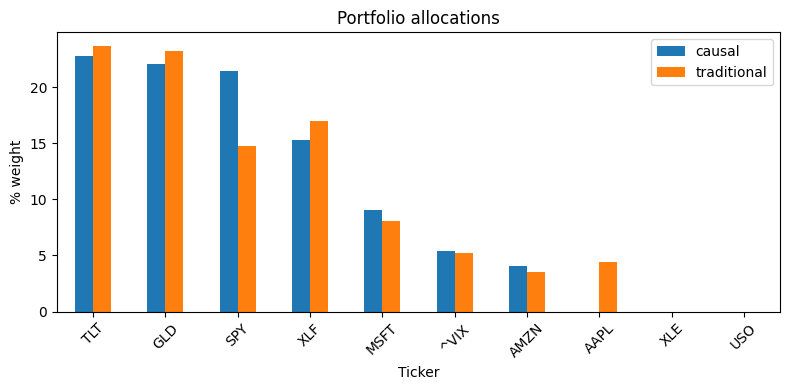

In [14]:
wgt = (
    pd.DataFrame({k: v["w"] for k, v in results.items()}, index=trainval_raw.columns)
    .mul(100)
    .sort_values(by="causal", ascending=False)
)
wgt.plot(kind="bar", figsize=(8, 4), rot=45)
plt.ylabel("% weight")
plt.title("Portfolio allocations")
plt.tight_layout()
plt.show()

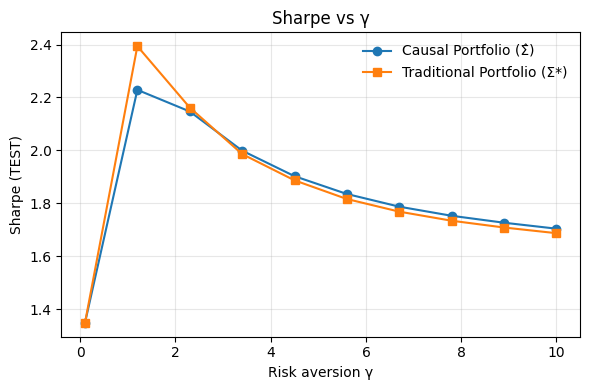

In [15]:
gammas        = np.linspace(0.1, 10, 10)
mu_test       = test_raw.mean() * 252
cov_test      = np.cov(test_raw.values.T) * 252

sharpe_c, sharpe_t = [], []

for g in gammas:
    w_c = solver_tv._solve(solver_tv.cov,        gamma=g)  
    w_t = solver_tv._solve(solver_tv.sample_cov, gamma=g)   

    sharpe_c.append((mu_test @ w_c) / np.sqrt(w_c @ cov_test @ w_c))
    sharpe_t.append((mu_test @ w_t) / np.sqrt(w_t @ cov_test @ w_t))

import matplotlib.pyplot as plt
plt.figure(figsize=(6,4))
plt.plot(gammas, sharpe_c, "-o", label="Causal Portfolio (Σ̂)")
plt.plot(gammas, sharpe_t, "-s", label="Traditional Portfolio (Σ*)")
plt.xlabel("Risk aversion γ"); plt.ylabel("Sharpe (TEST)")
plt.title("Sharpe vs γ")
plt.grid(alpha=.3); plt.legend(frameon=False); plt.tight_layout(); plt.show()

<Figure size 800x400 with 0 Axes>

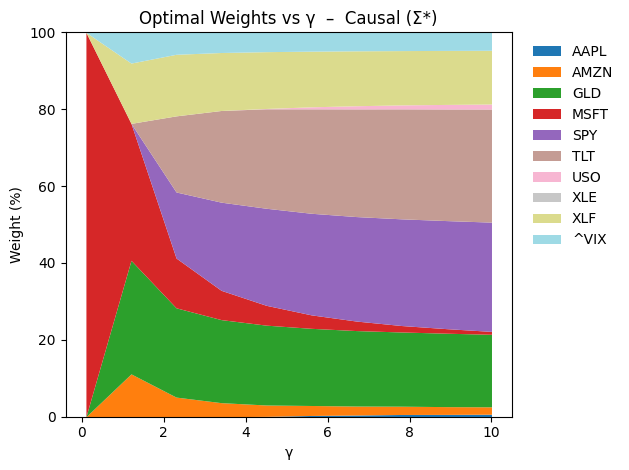

<Figure size 800x400 with 0 Axes>

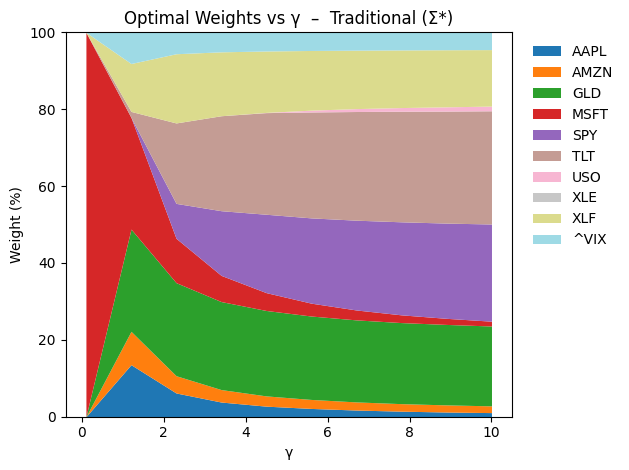

In [16]:
gammas = np.linspace(0.1, 10, 10)

w_causal = pd.DataFrame(
    [solver_tv._solve(solver_tv.cov, g) for g in gammas],
    columns=solver_tv.assets, index=gammas
) * 100         # % pesos

plt.figure(figsize=(8,4))
w_causal.plot(kind="area", stacked=True, linewidth=0, cmap="tab20")
plt.title("Optimal Weights vs γ  –  Causal (Σ*)")
plt.xlabel("γ"); plt.ylabel("Weight (%)")
plt.ylim(0,100); plt.legend(bbox_to_anchor=(1.02,1), loc="upper left", frameon=False)
plt.tight_layout(); plt.show()

w_trad = pd.DataFrame(
    [solver_tv._solve(solver_tv.sample_cov, g) for g in gammas],
    columns=solver_tv.assets, index=gammas
) * 100

plt.figure(figsize=(8,4))
w_trad.plot(kind="area", stacked=True, linewidth=0, cmap="tab20")
plt.title("Optimal Weights vs γ  –  Traditional (Σ*)")
plt.xlabel("γ"); plt.ylabel("Weight (%)")
plt.ylim(0,100); plt.legend(bbox_to_anchor=(1.02,1), loc="upper left", frameon=False)
plt.tight_layout(); plt.show()


In [17]:
def plot_dag_pretty(dag: nx.DiGraph):
    """
    Hierarchical DAG plot (Graphviz 'dot' layout).  Colours current-time nodes
    blue, lagged nodes orange; arrows styled for clarity.
    """
    try:
        pos = nx.nx_agraph.graphviz_layout(dag, prog="dot")  # <-- needs pygraphviz
    except Exception:
        pos = nx.shell_layout(dag)  # reasonable fallback

    present   = [n for n in dag if "_t-" not in n]
    lagged    = [n for n in dag if n not in present]

    plt.figure(figsize=(10, 6))
    nx.draw_networkx_nodes(dag, pos, nodelist=present,  node_color="#1f77b4",
                           node_size=700, alpha=0.9, label="t")
    nx.draw_networkx_nodes(dag, pos, nodelist=lagged,   node_color="#ff7f0e",
                           node_size=700, alpha=0.9, label="t-lag")
    nx.draw_networkx_labels(dag, pos, font_size=8, font_color="white")
    nx.draw_networkx_edges(dag, pos,
                           arrows=True, arrowstyle="-|>", arrowsize=12,
                           width=1.2, connectionstyle="arc3,rad=0.1")
    plt.legend(scatterpoints=1, frameon=False, loc="lower left")
    plt.title("Estimated causal DAG")
    plt.axis("off")
    plt.tight_layout()
    plt.show()

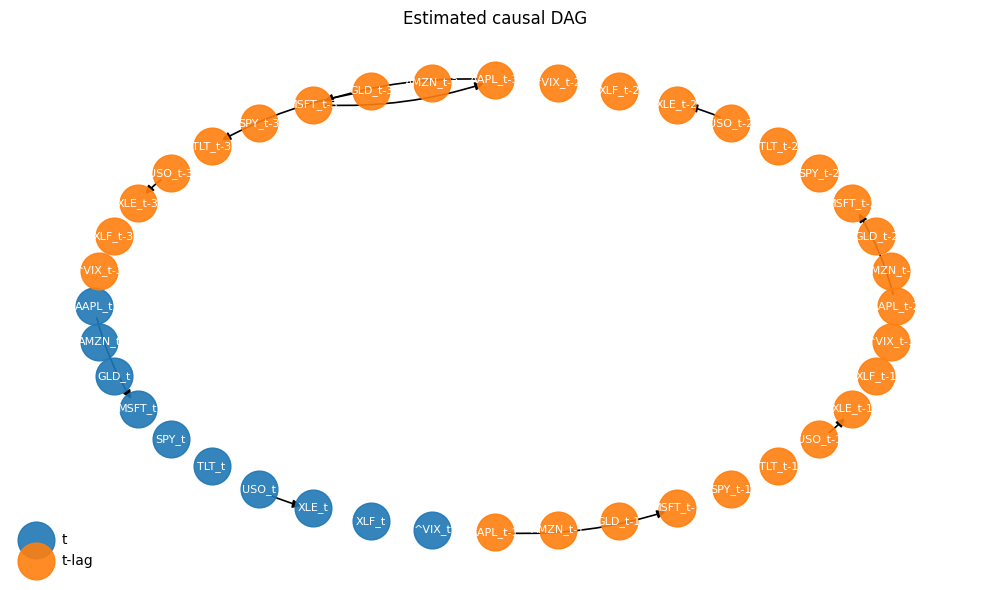

In [18]:
plot_dag_pretty(dag)